In [ ]:
import pandas as pd 
import geopandas as gpd 
import os 
import sys
import glob
from shapely import unary_union
import torch
import numpy as np 
import pickle

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

FOLDER_PATH = '../../../../data/rrochas/prediction_validation' 
save_path = f"{FOLDER_PATH}/POIs"
PATH_iris = f'{FOLDER_PATH}/lyon_iris_shapefile'


In [76]:
globals()[f"data_{osmid}_Instagram_DL"]

array([[ 7510335.,  7906892.,  6387126., ..., 11962942., 10839491.,
          683991.],
       [ 9149695.,  8821326.,  8318998., ..., 16048459., 13648922.,
         1507915.],
       [10353090., 10537250., 10065951., ..., 12473445., 12298696.,
          908251.],
       ...,
       [ 9852417.,  8707921.,  5504729., ...,  8541916.,  9707521.,
          826582.],
       [  485200.,   509160.,   815569., ...,   820152.,  2630704.,
           73206.],
       [ 1314587.,  1938896.,  2905897., ...,  3422777.,  5156388.,
          264635.]])

In [ ]:
save_folder = '../../../../data/rrochas/prediction_validation/POIs/netmob_POI_Lyon/InputsEpsilon/AMP'
data_app = np.load(open(f"{save_folder}/data.npy","rb"))
metadata = pickle.load(open(f"{save_folder}/metadata.pkl","rb"))
data_app.shape

(68, 2, 2, 7392)

In [81]:
path = '/home/rrochas/prediction-validation/../../../../data/rrochas/prediction_validation/POIs/netmob_POI_Lyon/Inputs/agg_TS/station_epsilon300/Periscope/DL'

np.load(open(f"{path}/data.npy","rb"))


array([[ 1611.,  4419.,  1959., ...,  6168.,  2998.,   147.],
       [ 9305.,  4877.,  2991., ..., 14587.,  2285.,   484.],
       [ 2253.,  3098.,  3080., ...,   486., 10983.,  1318.],
       ...,
       [ 1833.,  2954.,  5791., ...,   579.,  5499.,  6031.],
       [ 4799.,  2104.,   543., ...,    74.,  1401.,   447.],
       [ 5458.,  4187.,  2251., ...,  6400.,   678.,     0.]])

In [48]:
import numpy as np 
import pickle
save_folder = '/home/rrochas/prediction-validation/../../../../data/rrochas/prediction_validation/POIs/netmob_POI_Lyon/Inputs/agg_TS/station_epsilon100/Instagram/DL'
data = np.load(open(f"{save_folder}/data.npy",'rb'))
data.shape

(40, 7392)

## Load Time-Serie of a POI :
we have to define : 
- app  (['Instagram','Facebook','Uber','Google_Maps','Waze','Spotify','Deezer','Telegram','Facebook_Messenger','Snapchat','WhatsApp','Twitter', 'Pinterest'])
- transfer_mode (['DL','UL'])
- tag   (['park','university','stadium','shop','nightclub','station'])

,69837,69838,69839,70124,70125,70126,70411,70412,70413
2019-03-16 00:00:00,61558.0,51913.0,36852.0,61742.0,45718.0,32403.0,59299.0,39548.0,29770.0
2019-03-16 00:15:00,149082.0,103979.0,51959.0,146765.0,96006.0,43552.0,121719.0,74265.0,38763.0
2019-03-16 00:30:00,82022.0,61609.0,38569.0,87722.0,62556.0,36515.0,81148.0,54888.0,36612.0
2019-03-16 00:45:00,109283.0,74286.0,33663.0,109101.0,68626.0,28229.0,89395.0,51159.0,23432.0
2019-03-16 01:00:00,56564.0,54622.0,42245.0,51379.0,42503.0,35651.0,47279.0,34524.0,28922.0


<Axes: >

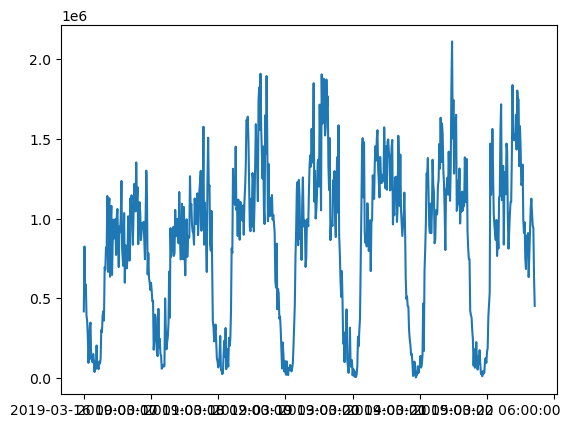

In [5]:
app = 'Instagram'
transfer_mode = 'DL'
tag = 'park'
expanded = '' # _expanded 

list_netmob_POI_paths = glob.glob(f"{FOLDER_PATH}/POIs/netmob_POI_Lyon{expanded}/{tag}/{app}/*_{transfer_mode}.csv")
path = list_netmob_POI_paths[0]
osmid = path.split('/')[-1][3:-7]
df = pd.read_csv(path,index_col = 0)
display(df.head())
df.sum(axis=1).iloc[:96*7].plot()

### Localise the POI: 

In [3]:
gdf_POI_2_tile_ids = gpd.read_file(f"{save_path}/gdf_POI_2_tile_ids.geojson")
gdf_POI_2_tile_ids.tile_ids = gdf_POI_2_tile_ids.tile_ids.apply(lambda str_tile_id: list(map(int,str_tile_id.split(','))))
gdf_POI_2_tile_ids.geometry =  gdf_POI_2_tile_ids.geometry.apply(lambda multipoly : unary_union(multipoly))

name:  Parc de la Cerisaie
geometry: 


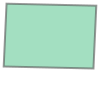

number of tile-ids:  9


In [6]:
gdf_POI_i = gdf_POI_2_tile_ids[(gdf_POI_2_tile_ids['id'] == osmid) &
                   (gdf_POI_2_tile_ids['type'] == f"POI{expanded}") ]
print('name: ',gdf_POI_i.name.values[0])
print('geometry: ')
display(gdf_POI_i.geometry.values[0])
print('number of tile-ids: ',len(gdf_POI_i.tile_ids.values[0]))

## Associate POI to Spatial unit : 
### Get Distance matrix from spatial unit to POIs (in km)

In [7]:
# Get centroids of POIs, projection 2154
centroids_POIs = gdf_POI_2_tile_ids['geometry'].centroid.to_crs('epsg:2154')

# Get centroids of Stations, projection 2154
stations_init  = gdf_POI_2_tile_ids[gdf_POI_2_tile_ids['type'] == 'station']
centroids_stations = stations_init['geometry'].centroid.to_crs('epsg:2154')

# Get distance matrix in km: 
dist_matrix  = centroids_stations.apply(lambda centroid: centroid.distance(centroids_POIs))/1000

/tmp/ipykernel_167208/3532024595.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_POIs = gdf_POI_2_tile_ids['geometry'].centroid.to_crs('epsg:2154')
/tmp/ipykernel_167208/3532024595.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_stations = stations_init['geometry'].centroid.to_crs('epsg:2154')


### Buffer < epsilon km

In [8]:
# Set epsilon (1km)
epsilon = 1
stations_init['associated_POIs_index'] = stations_init.apply(lambda row: list(dist_matrix.loc[row.name][dist_matrix.loc[row.name] < epsilon].index),axis=1 )

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Assign POIs also to the closest spatial unit: 

In [9]:
# Assign POIs to the closest spatial unit: 
closest_POI = dist_matrix.transpose().idxmin(axis=1)
stations_init['associated_POIs_index'] = stations_init.apply(lambda row : list(set(closest_POI[closest_POI==row.name].index) |set(row['associated_POIs_index'])),axis=1)

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [10]:
def get_POI_Time_Serie(osmid,tag,app,transfer_mode,expanded):
    path_df = f"{FOLDER_PATH}/POIs/netmob_POI_Lyon{expanded}/{tag}/{app}/df_{osmid}_{transfer_mode}.csv"
    time_serie = pd.read_csv(path_df,index_col = 0).sum(axis=1)
    return(time_serie)

def run_init(apps,id_station,expanded,transfer_modes):
    # INIT metadata and save folder for each app:
    metadata = {'apps':apps,
                'id_station':id_station,
                'expanded':expanded,
                'transfer_modes':transfer_modes,
                'shape': '[len(apps),len(osmid),len(transfer_modes),len(dates)]'
                }
    
    save_folder0 = f"{FOLDER_PATH}/POIs/netmob_POI_Lyon{expanded}/Inputs"
    save_folder = f"{save_folder0}/{id_station}"
    if not os.path.exists(save_folder0):
        os.mkdir(save_folder0)
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    print(id_station)
    return(metadata,save_folder)

def get_list_osmid(stations_init,gdf_POI_2_tile_ids,id_station,expanded):
    # Get gdf of POIs associated to id_station :
    assigned_POIs = stations_init[stations_init['id'] == id_station]['associated_POIs_index']
    gdf_POIs = gdf_POI_2_tile_ids.loc[assigned_POIs.values[0]]
    gdf_POIs = gdf_POIs[gdf_POIs['type'] == f"POI{expanded}"]
    
    # Init the research by looking at the subway station : 
    list_assigned_osmid = [id_station]
    list_tag_osmid = ['station']
    # Add the associated POIs:

    list_assigned_osmid = list_assigned_osmid+list(gdf_POIs['id'])
    list_tag_osmid = list_tag_osmid+list(gdf_POIs['tag'])
    if False: 
        # Init the research by looking at the subway station : 
        list_assigned_osmid = [id_station]
        list_tag_osmid = ['station']
        # Get the POI ids and tag associated to the subway station : 
        gdf = globals()[f"POIs{expanded}"]
        list_assigned_osmid = list_assigned_osmid+list(gdf[gdf['id_closest'] == id_station]['id'])
        list_tag_osmid = list_tag_osmid+list(gdf[gdf['id_closest'] == id_station]['tag'])
    return list_assigned_osmid,list_tag_osmid

def build_npy_for_each_spatial_unit(apps,stations_init,gdf_POI_2_tile_ids,id_stations,expanded,transfer_modes):
    for id_station in id_stations:
        ## INIT
        (metadata,save_folder) = run_init(apps,id_station,expanded,transfer_modes)
        list_assigned_osmid,list_tag_osmid = get_list_osmid(stations_init,gdf_POI_2_tile_ids,id_station,expanded)
        # __Update metadata:
        metadata.update({'osmid':list_assigned_osmid,
                                'tags':list_tag_osmid})
        ## ------------------------

        List_tensor_apps = []
        # Build Tensor of the NetMob TimeSerie associated to a spatial unit (subway station):
        for app in apps:

            # Tackle Tile-ids around station : 
            List_tensor_osmid = []
            for osmid,tag in zip(list_assigned_osmid,list_tag_osmid):
                List_time_series = []
                ## Tackle transfer modes: 
                for transfer_mode in transfer_modes:
                    time_serie =get_POI_Time_Serie(osmid,tag,app,transfer_mode,expanded).sort_index()  # Be sure index are ordered in an ascending manner
                    List_time_series.append(time_serie.values)
                # ---> Torch.Tensor size :[2,len(dates)] torch.Tensor  (or convert into [1,len(dates)] if only one transfer-mode is considered
                T_transfer = torch.Tensor(np.array(List_time_series))
                List_tensor_osmid.append(T_transfer)

            # ---> Torch.Tensor size : [len(POIs associated to station i) + 1,2,len(dates)]
            T_osmids_around_station = torch.stack(List_tensor_osmid)
            List_tensor_apps.append(T_osmids_around_station)

        metadata.update({'dates':time_serie.index})
        T_apps_on_station_i = torch.stack(List_tensor_apps)
        # Save NetMob Tensor and the MetaData:
        np.save(open(f"{save_folder}/data.npy","wb"),T_apps_on_station_i.numpy())
        pickle.dump(metadata,open(f"{save_folder}/metadata.pkl","wb"))


id_stations = list(stations_init['id'].unique())
tags = ['park','stadium','university','shop','nightclub','parkings','theatre','iris','transit','public_transport']
apps = ['Instagram','Facebook','Uber','Google_Maps','Waze','Spotify','Deezer','Telegram','Facebook_Messenger','Snapchat','WhatsApp','Twitter', 'Pinterest']
transfer_modes = ['DL','UL'] # ['DL'] # ['UL'], # ['DL','UL']
expanded = '_expanded' # '_expanded'  # ''
# Get set of time-serie For each Spatial-Unit

if False: 
    for expanded in ['','_expanded']: # '_expanded'  # ''
        build_npy_for_each_spatial_unit(apps,stations_init,gdf_POI_2_tile_ids,id_stations,expanded,transfer_modes)


In [15]:
id_station = 'GER'
list_assigned_osmid,list_tag_osmid = get_list_osmid(stations_init,gdf_POI_2_tile_ids,id_station,expanded)
gdf_POI_2_tile_ids[(gdf_POI_2_tile_ids['id'].isin(list_assigned_osmid))&
                   ~(gdf_POI_2_tile_ids['type'].isin(['POI_expanded']))&
                   ~(gdf_POI_2_tile_ids['tag'].isin(['iris']))
                  ].explore('tag',tiles="Cartodb Positron")

In [20]:
gdf_POI_2_tile_ids[((gdf_POI_2_tile_ids['id'].isin(list_assigned_osmid))&
                   ~(gdf_POI_2_tile_ids['type'].isin(['POI_expanded']))&
                   (gdf_POI_2_tile_ids['tag'].isin(['iris'])))|
                   ((gdf_POI_2_tile_ids['id'].isin(list_assigned_osmid))&
                    (gdf_POI_2_tile_ids['type'].isin(['station_expanded']))&
                    (gdf_POI_2_tile_ids['tag'].isin(['station']))
                       )
                  ].explore('id',tiles="Cartodb Positron")

In [33]:
gdf_plot = gdf_POI_2_tile_ids[(gdf_POI_2_tile_ids['type'].isin(['station_expanded']))|
                    ((gdf_POI_2_tile_ids['tag'].isin(['iris']))& ~(gdf_POI_2_tile_ids['type'].isin(['POI_expanded'])))
]
gdf_plot['type'] = gdf_plot['type'].apply(lambda x: 'IRIS' if x=='POI' else 'Station' )
m = gdf_plot.explore('type',tiles="Cartodb Positron",cmap= 'viridis')  # Color for the boundaries)

if False : 
    outfp = "IRIS.html"
    m.save(outfp)

m

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
gdf_plot

,type,tag,id,name,tile_ids,geometry
581,POI,iris,692590602.0_0,Ernest Renan,"[51786, 51787, 51788, 51789, 51790, 51791, 517...","POLYGON ((4.85166 45.71645, 4.85037 45.71648, ..."
671,POI,iris,691420102.0_0,Le Confluent,"[51756, 51757, 51758, 52043, 52044, 52045, 520...","POLYGON ((4.81078 45.72186, 4.81082 45.72276, ..."
971,POI,iris,693870703.0_0,Cité Jardin,"[54640, 54641, 54642, 54643, 54644, 54645, 549...","POLYGON ((4.83024 45.72593, 4.83028 45.72682, ..."
1037,POI,iris,693870801.0_0,Marcel Mérieux,"[54640, 54927, 55213, 55214, 55215, 55500, 555...","POLYGON ((4.82792 45.73138, 4.82663 45.73141, ..."
1075,POI,iris,693870603.0_0,Le Rhône,"[56930, 56931, 56932, 56933, 57217, 57218, 572...","POLYGON ((4.82543 45.73323, 4.82415 45.73326, ..."
1089,POI,iris,693870901.0_0,La Mouche-Le Port,"[48620, 48621, 48904, 48905, 48906, 48907, 489...","POLYGON ((4.82450 45.71255, 4.82454 45.71345, ..."
1239,POI,iris,693870704.0_0,Jean-Jaurès Sud,"[56364, 56365, 56366, 56651, 56652, 56653, 566...","POLYGON ((4.83434 45.73124, 4.83305 45.73126, ..."
1245,POI,iris,693870802.0_0,Tony Garnier,"[51766, 51767, 52052, 52053, 52054, 52055, 523...","POLYGON ((4.81977 45.72166, 4.81848 45.72169, ..."
5332,station_expanded,station,GER,GER,"[55213, 55214, 55215, 54926, 54927, 54928, 546...","POLYGON ((4.83152 45.72590, 4.83024 45.72593, ..."


In [40]:
gdf_plot = gdf_POI_2_tile_ids[(gdf_POI_2_tile_ids['id'].isin(list_assigned_osmid))&
                              (
                    ((gdf_POI_2_tile_ids['tag'].isin(['iris']))& ~(gdf_POI_2_tile_ids['type'].isin(['POI_expanded'])))|
                    (gdf_POI_2_tile_ids['type'].isin(['station_expanded'])) 
                    )
]

id2name = {id_i:f"IRIS {k}" for k,id_i in enumerate(gdf_plot['id'][gdf_plot['tag']=='iris'])}
id2name.update({id_station:'Station'})
gdf_plot['id'] = gdf_plot.apply(lambda row: id2name[row['id']],axis=1)
m = gdf_plot.explore('id',tiles="Cartodb Positron",cmap= 'viridis')  # Color for the boundaries)

if False : 
    outfp = "IRIS_station_i.html"
    m.save(outfp)
m

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Load saved data at a specific app:

In [25]:
from constants.paths import SELECTED_APPS ,TRANSFER_MODE,SELECTED_TAGS

id_station = 'GER'   #CHARPENNES
expanded = '' # _expanded 
save_folder = f"{FOLDER_PATH}/POIs/netmob_POI_Lyon{expanded}/Inputs/{id_station}"
data_app = np.load(open(f"{save_folder}/data.npy","rb"))
metadata = pickle.load(open(f"{save_folder}/metadata.pkl","rb"))
print('data_app.shape: ',data_app.shape)
print('shape order: ',metadata['shape'])

pos_selected_apps = [k for k,app in enumerate(metadata['apps']) if app in SELECTED_APPS]
pos_selected_modes = [k for k,mode in enumerate(metadata['transfer_modes']) if mode in TRANSFER_MODE]
pos_selected_tags = [k for k,tag in enumerate(metadata['tags']) if tag in SELECTED_TAGS]
time_serie_stations = data_app[pos_selected_apps,pos_selected_tags,pos_selected_modes,:].reshape(-1,7392)

In [27]:
tags = metadata['tags']
osmid = metadata['osmid']

tag_unique = list(set(tags))
for tag in tag_unique:
    globals()[f"osmid_{tag}"] = [osmid[k] for k,tag_i in enumerate(tags) if tag_i == tag]
    globals()[f"pos_{tag}"] = [k for k,tag_i in enumerate(tags) if tag_i == tag]

In [1]:
from plotting.TS_analysis import plot_TS


for tag in tag_unique:
    print(f'Tag: {tag}')
    globals()[f"pos_{tag}"] = [k for k,tag_i in enumerate(tags) if tag_i == tag]
    df = pd.DataFrame()
    df.index = pd.date_range(start='03/16/2019', end='06/1/2019', freq='15min')[:-1]
    print('Number of POIs in the TimeSerie: ',len(globals()[f"pos_{tag}"]))
    for j,mode in enumerate(['DL','UL']):
        for i,app in enumerate(metadata['apps']):
            if (app == 'Facebook') |(app == 'Instagram') | (app == 'Uber') | (app == 'Waze')| (app == 'Google_Maps')| (app == 'Twitter')| (app == 'WhatsApp')| (app == 'Spotify')| (app == 'Deezer'):
                time_serie_stations = data_app[i,globals()[f"pos_{tag}"],j,:].reshape(-1,7392)
                mini = time_serie_stations.min(axis=1).reshape(-1,1)
                maxi = time_serie_stations.max(axis=1).reshape(-1,1)
                norm_time_serie_stations = (time_serie_stations-mini)/(maxi-mini)
                summed_time_serie_stations = norm_time_serie_stations.mean(axis=0)
                df[f'{app}_{mode}_summed_station'] = summed_time_serie_stations

    plot_TS(df,width=1200,height=600,bool_show=True)  #.iloc[-96*14+(4*21):-96*13]


In [ ]:
gdf_POIs = gdf_POI_2_tile_ids[gdf_POI_2_tile_ids['type']=='POI']
for tag in gdf_POIs.tag.unique():
    print(tag,': ',len(gdf_POIs[gdf_POIs.tag == tag]))

park :  47
stadium :  3
university :  40
shop :  20
nightclub :  26
parkings :  76
theatre :  25
iris :  430
transit :  19
public_transport :  1977


### Mauvais chemin de sauvegarde la première fois, besoin de déplacer certains fichier.

In [2]:
if False:
    import shutil
    from load_inputs.subway_in import get_trigram_correspondance
    POI_path = '../../../../data/rrochas/prediction_validation/POIs'
    apps = ['Instagram','Facebook','Uber','Google_Maps','Waze','Spotify','Deezer','Telegram','Facebook_Messenger','Snapchat','WhatsApp','Twitter', 'Pinterest']

    for expanded in ['','_expanded']:
        new_folder_path = f'{POI_path}/netmob_POI_Lyon{expanded}/station'
        if not os.path.exists(new_folder_path):
            os.mkdir(new_folder_path)
        for app in apps:
            new_folder_path_app = f'{new_folder_path}/{app}'
            if not os.path.exists(new_folder_path_app):
                os.mkdir(new_folder_path_app)
            
            current_folder_path= f'{POI_path}/netmob_POI_Lyon{expanded}/nightclub/{app}'

            list_csv_path = glob.glob(f"{current_folder_path}/*")
            for k,file_path in enumerate(list_csv_path) :
                tag_id = file_path.split('/')[-1][3:-7]
                if tag_id in list(get_trigram_correspondance().COD_TRG):
                    shutil.move(file_path, new_folder_path_app)  # mv file_path new_folder_path_app

# Test Load NetMob POI dans le framework : 
### Import and Functions: 

## Build the different dataloader that we will use:
    '''
    dataset_names in list of : 
    ---------------------------
    >>["subway_in"],
    >>["subway_in","calendar"],
    >>['subway_in','netmob_POIs'],
    >>['netmob_POIs']
    >>['METR_LA'],
    >>['PEMS_BAY'],
    >>['data_bidon'],
    >>['data_bidon','netmob_bidon'],
    vision_model_name in : 
    ---------------------------
    >> 'VariableSelectionNetwork'
    >> None
    ''' 

In [2]:
from examples.benchmark import get_inputs

dataset_for_coverage = ['subway_in','netmob_POIs'] 
for dataset_names,vision_model_name,name_ds in zip([['netmob_POIs'],['subway_in','netmob_POIs'],['subway_in']],['VariableSelectionNetwork','VariableSelectionNetwork',None],['POI','subway_POI','subway']):

    # GET PARAMETERS
    model_name = 'STGCN'
    args = local_get_args(model_name,
                            None,
                            dataset_names=dataset_names,
                            dataset_for_coverage=dataset_for_coverage,
                            modification = {})
    trial_id = get_trial_id(args,vision_model_name=vision_model_name)
    K_fold_splitter,K_subway_ds,dic_class2rpz = get_inputs(args,folds=[0])
    globals()[f"args_{name_ds}"] = args
    globals()[f"ds_{name_ds}"] = K_subway_ds[0]

40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 40, 7]) Utarget size:  torch.Size([6238, 40, 1])
U_train size:  torch.Size([3742, 40, 7]) Utarget_train size:  torch.Size([3742, 40, 1])
U_valid size:  torch.Size([1248, 40, 7]) Utarget_valid size:  torch.Size([1248, 40, 1])
U_test size:  torch.Size([1247, 40, 7]) Utarget_test size:  torch.Size([1247, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)
mean_values:  torch.Size([1, 48])
tensor size:  torch.Size([4, 48])
mean_values repeated:  torch.Size([4, 48])
>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 48, 7]) Utarget size:  torch.Size([6238, 48, 1])
U_train size:  torch.Size([3742, 48, 

## Try to save to avoid 2min re-loading each time...
Ne fonctionne pas 

In [ ]:
if False : 
    import pickle
    # Save:
    for name_ds in ['POI','subway_POI','subway']:
        pickle.dump(globals()[f"args_{name_ds}"],open(f"{parent_dir}/save/args_{name_ds}","wb"))
        pickle.dump(globals()[f"ds_{name_ds}"],open(f"{parent_dir}/save/ds_{name_ds}","wb"))

    # Load:
    for name_ds in ['POI','subway_POI','subway']:
        globals()[f"args_{name_ds}"] = pickle.load(open(f"{parent_dir}/save/args_{name_ds}","rb"))
        globals()[f"ds_{name_ds}"] = pickle.load(open(f"{parent_dir}/save/ds_{name_ds}","rb"))

## Train and Visualisation :  
have to associate dataset_name to ds_name as above : 
- ['netmob_POIs'] <-> 'POI'
- ['subway_in','netmob_POIs'] <-> 'subway_POI'
- ['subway_in'] <-> 'subway'

In [ ]:
from examples.train_model_on_k_fold_validation import load_configuration
from examples.train_model_on_k_fold_validation import load_configuration
from examples.train_and_visu_non_recurrent import update_args_train_visu, visualisation,load_all

trial_id = 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2024_12_04_12_25_63821'
args = load_configuration(trial_id,load_config=True,epochs=30)

model_names = ['STGCN']  #  ['MTGNN','CNN','STGCN','LSTM','GRU','RNN'] #'DCRNN',
save_folder = 'benchmark/fold0/'




for dataset_names,vision_model_name,name_ds in zip([['netmob_POIs'],['subway_in','netmob_POIs'],['subway_in']],['VariableSelectionNetwork','VariableSelectionNetwork',None],['POI','subway_POI','subway']):
    df_loss,df_results = pd.DataFrame(),pd.DataFrame()
    modification = {'epochs' : 15, #100,
                    }
    for model_name in model_names: 
        trainer,df_results = update_args_train_visu(model_name,name_ds,dataset_names,vision_model_name,dataset_for_coverage,modification,dic_class2rpz,df_loss,df_results,save_folder)

In [3]:
model_names = ['STGCN']  #  ['MTGNN','CNN','STGCN','LSTM','GRU','RNN'] #'DCRNN',
save_folder = 'benchmark/fold0/'


for dataset_names,vision_model_name,name_ds in zip([['netmob_POIs'],['subway_in','netmob_POIs'],['subway_in']],['VariableSelectionNetwork','VariableSelectionNetwork',None],['POI','subway_POI','subway']):
    df_loss,df_results = pd.DataFrame(),pd.DataFrame()
    modification = {'epochs' : 15, #100,
                    }
    for model_name in model_names: 
        trainer,df_results = update_args_train_visu(model_name,name_ds,dataset_names,vision_model_name,dataset_for_coverage,modification,dic_class2rpz,df_loss,df_results,save_folder)



>>>>Training STGCN on ['netmob_POIs']
40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

PREDICTION WILL BE BASED SOLELY ON CONTEXTUAL DATA !



Model size: 0.001GB
number of total parameters: 1686822
number of trainable parameters: 1686822

start training
epoch: 0 
 min\epoch : 1.00
Estimated time for training: 14.6min 

Training Throughput:35.02 sequences per seconds
>>> Training complete in: 0:13:09.557386
>>> Training performance time: min 0.8117637634277344 avg 0.8736125230789185 seconds (+/- 0.07984834690074612)
>>> Loading performance time: min 0.0009622573852539062 avg 0.5013589656304734 seconds (+/- 1.0022661605467837)
>>> Forward performance time: 0.2511022925701713 seconds (+/- 0.022822811947798193)
>>> Backward performance time: 0.6476727305056289 seconds (+/- 0.07688950539098477)
>>> Plotting performance time: 4.332406180245536e-05 seconds (+/- 0.00014193100348502548)
>>> Saving performance time: 9.172272404034933 seconds (+/- 3.8760755048328894)
>>> PI-tracking performance time: 5.3303582327706474e-06 seconds (+/- 1.7809887074099377e-06)
>>> Scheduler-update performance time: 3.8998467581612724e-06 seconds (+/- 9.

Loading BokehJS ...


>>>>Training STGCN on ['subway_in', 'netmob_POIs']
40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Model size: 0.002GB
number of total parameters: 1801510
number of trainable parameters: 1801510

start training
epoch: 0 
 min\epoch : 0.98
Estimated time for training: 14.4min 

Training Throughput:35.08 sequences per seconds
>>> Training complete in: 0:13:28.785190
>>> Training performance time: min 0.8169829845428467 avg 0.8636411428451538 seconds (+/- 0.09508875817479294)
>>> Loading performance time: min 0.0009016990661621094 avg 0.5178414970917902 seconds (+/- 1.121662661592626)
>>> Forward performance time: 0.26014893841028863 seconds (+/- 0.03500444620437155)
>>> Backward performance time: 0.6396818557292304 seconds (+/- 0.0863118695341749)
>>> Plotting performance time: 1.1427061898367746e-05 seconds (+/- 2.8176578225165126e-05)
>>> Saving performance time: 9.331559985876083 seconds (+/- 3.2045798997356676)
>>> PI-tracking performance time: 3.96796635219029e-06 seconds (+/-

Loading BokehJS ...


>>>>Training STGCN on ['subway_in']
40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Model size: 0.001GB
number of total parameters: 207233
number of trainable parameters: 207233

start training
epoch: 0 
 min\epoch : 0.04
Estimated time for training: 0.4min 

Training Throughput:1505.71 sequences per seconds
>>> Training complete in: 0:00:23.245170
>>> Training performance time: min 0.017311811447143555 avg 0.020296573638916016 seconds (+/- 0.002338935184430705)
>>> Loading performance time: min 0.00013446807861328125 avg 0.015221968031766122 seconds (+/- 0.05888823178036903)
>>> Forward performance time: 0.006910848032875997 seconds (+/- 0.0010182303713383628)
>>> Backward performance time: 0.008214346394551873 seconds (+/- 0.001738339336726953)
>>> Plotting performance time: 1.2874603271484375e-05 seconds (+/- 2.8349477213806732e-05)
>>> Saving performance time: 0.3608452081680298 seconds (+/- 0.10825633372528463)
>>> PI-tracking performance time: 5.3303582327706474e-06 seconds

Loading BokehJS ...

In [4]:
model_names = ['STGCN']  #  ['MTGNN','CNN','STGCN','LSTM','GRU','RNN'] #'DCRNN',
save_folder = 'benchmark/fold0/'
df_loss,df_results = pd.DataFrame(),pd.DataFrame()
modification = {'epochs' : 10, #100,
                }

for dataset_names,vision_model_name in zip([['netmob_POIs'],['subway_in','netmob_POIs'],['subway_in']],['VariableSelectionNetwork','VariableSelectionNetwork',None],['POI','subway_POI','subway']):

    # GET PARAMETERS
    dataset_for_coverage = ['subway_in','netmob_POIs'] 
    #assert DATA_TO_PREDICT in dataset_names, f'You are trying to predict {DATA_TO_PREDICT} with only these data: {dataset_names}'
    save_folder = 'benchmark/fold0/'
    df_loss,df_results = pd.DataFrame(),pd.DataFrame()
    modification = {'epochs' : 10, #100,
                    }
    
    # Init model for training:
    model_name = model_names[0]
    print(f'\n>>>>Training {model_name} on {dataset_names}')
    # Tricky but here we net to set 'netmob' so that we will use the same period for every combination

    args = local_get_args(model_name,
                            None,
                            dataset_names=dataset_names,
                            dataset_for_coverage=dataset_for_coverage,
                            modification = modification)
    trial_id = get_trial_id(args)
    K_fold_splitter,K_subway_ds,dic_class2rpz = get_inputs(args,folds=[0])
    ds = K_subway_ds[0]

    # Benchmark on all the other models. Avoid to re-build dataloader if dataset_names are the same
    for model_name in model_names[1:]:  
        print(f'\n>>>>Training {model_name} on {dataset_names}')
        args = local_get_args(model_name,
                                args,
                                dataset_names=dataset_names,
                                dataset_for_coverage=dataset_for_coverage,
                                modification = modification)
        trial_id = get_trial_id(args)
        trainer,df_loss = train_on_ds(model_name,ds,args,trial_id,save_folder,dic_class2rpz,df_loss)
        metrics = trainer.metrics
        df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer,metrics)
        visualisation(trainer,ds,training_mode = 'test',station = 'CHA')
    # ...

    print(df_results)
    #df_loss[[f"{model}_valid_loss" for model in model_names]].plot()
    #plt.show()
    df_results.to_csv(f'{parent_dir}/save/results/{trial_id}.csv')



>>>>Training STGCN on ['netmob_POIs']
40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 



>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 40, 7]) Utarget size:  torch.Size([6238, 40, 1])
U_train size:  torch.Size([3742, 40, 7]) Utarget_train size:  torch.Size([3742, 40, 1])
U_valid size:  torch.Size([1248, 40, 7]) Utarget_valid size:  torch.Size([1248, 40, 1])
U_test size:  torch.Size([1247, 40, 7]) Utarget_test size:  torch.Size([1247, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)
mean_values:  torch.Size([1, 4])
tensor size:  torch.Size([4, 4])
mean_values repeated:  torch.Size([4, 4])
>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 4, 7]) Utarget size:  torch.Size([6238, 4, 1])
U_train size:  torch.Size([3742, 4, 7]) Utarget_train size:  torch.Size([3742, 4, 1])
U_valid size:  torch.Size([1248, 4, 7]) Utarget_valid size:  torch.Size([1248, 4, 1])
U_test size:  torch.Size([1247

Loading BokehJS ...

   Model  Valid_loss  Valid_mse  Test_mse  Valid_mae  Test_mae  Valid_mape  \
0  STGCN    0.014962   0.014962   0.01144   0.079077  0.067978  116.501823   

   Test_mape  
0  99.443214  

>>>>Training STGCN on ['subway_in', 'netmob_POIs']
40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 40, 7]) Utarget size:  torch.Size([6238, 40, 1])
U_train size:  torch.Size([3742, 40, 7]) Utarget_train size:  torch.Size([3742, 40, 1])
U_valid size:  torch.Size([1248, 40, 7]) Utarget_valid size:  torch.Size([1248, 40, 1])
U_test size:  torch.Size([1247, 40, 7]) Utarget_test size:  torch.Size([1247, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)
mean_values:  torch.Size([1, 4])
tensor size:

Loading BokehJS ...

   Model  Valid_loss  Valid_mse  Test_mse  Valid_mae  Test_mae  Valid_mape  \
0  STGCN     0.00436    0.00436  0.004043   0.041741  0.038723   47.804058   

   Test_mape  
0  50.771957  

>>>>Training STGCN on ['subway_in']
40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 40, 7]) Utarget size:  torch.Size([6238, 40, 1])
U_train size:  torch.Size([3742, 40, 7]) Utarget_train size:  torch.Size([3742, 40, 1])
U_valid size:  torch.Size([1248, 40, 7]) Utarget_valid size:  torch.Size([1248, 40, 1])
U_test size:  torch.Size([1247, 40, 7]) Utarget_test size:  torch.Size([1247, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)

Fold n°0

Init Dataset:  torch.Size([2174, 40])
Number of N

Loading BokehJS ...

   Model  Valid_loss  Valid_mse  Test_mse  Valid_mae  Test_mae  Valid_mape  \
0  STGCN    0.003169   0.003169   0.00325   0.036193  0.035055   49.070866   

   Test_mape  
0   51.83205  


### Retrain if needed : 

In [12]:
df_loss,df_results = pd.DataFrame(),pd.DataFrame()
modification = {'epochs' : 100, #100,
                }
args = local_get_args(model_name,
                        args,
                        dataset_names=dataset_names,
                        dataset_for_coverage=dataset_for_coverage,
                        modification = modification)
trial_id = get_trial_id(args)
trainer,df_loss = train_on_ds(model_name,ds,args,trial_id,save_folder,dic_class2rpz,df_loss)
metrics = trainer.metrics
df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer,metrics)

NameError: name 'model_name' is not defined

### Visualisation and metrics: 

   Model  Valid_loss  Valid_mse  Test_mse  Valid_mae  Test_mae  Valid_mape  \
0  STGCN    0.004948   0.004948  0.005217   0.045141   0.04646   49.714939   

   Test_mape  
0  59.145782  


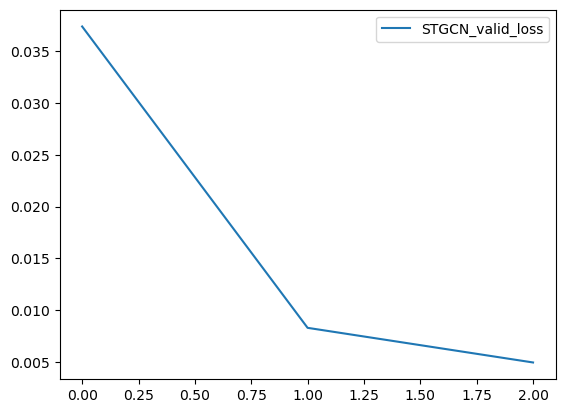

In [3]:
df_results = keep_track_on_model_metrics(trainer,df_results,model_names[0],trainer,metrics)
print(df_results)
df_loss[[f"{model}_valid_loss" for model in model_names]].plot()
df_results.to_csv(f'{parent_dir}/save/results/{trial_id}.csv')
plt.show()

In [6]:
from load_inputs.subway_in import get_trigram_correspondance

position_station = ds.contextual_positions['netmob_POIs']
LIST_COD_TRG = list(get_trigram_correspondance().COD_TRG)  # Associated list. position_station[k] correspond to LIST_COD_TRG[k]

ds.contextual_tensors['netmob_CHA']['train'].size()

torch.Size([1715, 12, 7])

# Sélection de l'information contenue dans les POIs, encodage, ajout dans le modèle
## Inspiration
### TFT:
- Contient des bloocs de 'Variable Selection' pour chaque Input à l'instant 't'. Que ce soit pour 'static', pour 'past time-depend input' (known ou unknown) ou pour 'futur' (known) 
    - On transform les inputs (Linear ou Embedding si categorical)
    - On passe dans un GRN (Gated Residual Network), un Gating Mechanism:
        - $GRN(X,X_c) = LayerNorm(X + GLU(\eta{_1}))$
        - $GLU(\eta) =\sigma(W_{4}\eta + b_{4})\odot (W_{5}\eta + b_{5})$
        - $\eta{_1} = W_{1}*\eta_{2} + b_{1},  \in\mathbb{R}^{d_{model}}$
        - $\eta{_2} =ELU(W_{2}*X + W_{3}*X_{c} + b_{2})\in\mathbb{R}^{d_{model}}$
        - $W_{i}\in \mathbb{R}^{d_{model}\times d_{model}}$
        - $\odot$ element wise hadamard product  

        - $ELU$ : Exponentil Linear Unit activation function 
    - On passe dans un gated module (softmax())

In [7]:
#from dl_models.TFT.Variable_selection_network import VariableSelectionNetwork

# Input VariableSelectionNetwork : [B,L,C], où C : nombre de 'past' variables
pos_notmob_POIs= ds.contextual_positions['netmob_POIs']
X,Y,C = next(iter(ds.dataloader['train']))

selected_station = 'CHA'
pos_CHA = [k for k,station in enumerate(LIST_COD_TRG) if station == selected_station][0]

# Shape: [B,C,L]
input_vsn = C[pos_CHA]

In [1]:
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Personnal import 
from examples.train_model_on_k_fold_validation import train_model_on_k_fold_validation

# 
trial_id = 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2024_12_04_12_25_63821'
epochs_validation = 30
train_model_on_k_fold_validation(trial_id,load_config=True,save_folder='K_fold_validation/training_with_HP_tuning',epochs=epochs_validation,hp_tuning_on_first_fold = True)


Training and Hyper-parameter tuning with Ray is not possible

>>>> Load best CONFIG
ARG:  vision_grn_h_dim
ARG:  vision_grn_out_dim

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 40, 7]) Utarget size:  torch.Size([6238, 40, 1])
U_train size:  torch.Size([3742, 40, 7]) Utarget_train size:  torch.Size([3742, 40, 1])
U_valid size:  torch.Size([1248, 40, 7]) Utarget_valid size:  torch.Size([1248, 40, 1])
U_test size:  torch.Size([1247, 40, 7]) Utarget_test size:  torch.Size([1247, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)
mean_values:  torch.Size([1, 28])
tensor size:  torch.Size([4, 28])
mean_values repeated:  torch.Size([4, 28])
>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 28, 7])

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1e4d3114b0>>
Traceback (most recent call last):
  File "/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
